# 用Cirq模拟量子隐形传态过程

这里我们用谷歌的Cirq框架来模拟量子隐形传态的过程：Alice这里有一个量子比特$|\psi\rangle$，通过量子隐形传态电路，把状态传送到Bob那里。

关于量子隐形传态的原理，请参见[我的相关文章](https://mp.weixin.qq.com/s?__biz=MzI4ODYxNDY5NA==&mid=2247484394&idx=1&sn=e167ed2e9427fe35ed5a0bc320b19a45&chksm=ec3af3a3db4d7ab5281f3d17ce86cd56e9043316667c9f51d23643cbd444b02535f2faf26cc1&scene=178&cur_album_id=1504407355969617921#rd)。

## 制备纠缠态的量子比特

要在Alice和Bob之间实现量子隐形传态，首先需要用到一对纠缠态的量子比特。这可以通过一个H门和一个CNOT门来实现：

<img src="./images/Entanglement.svg" width="320" />

为简化后面的量子电路，可以把这里的H门和CNOT门包装成一个自定义的复合门，这样也方便以后重用。我们把这个自定义门起名叫“纠缠门”（EntangleGate）。

In [81]:
import cirq
import numpy as np

# 创建一个自定义门 - “纠缠门”，输入2个量子比特
class EntangleGate(cirq.ops.gate_features.TwoQubitGate):
    # 内部就是一个H门和一个CNOT门
    def _decompose_(self, qubits):
        q0, q1 = qubits
        yield cirq.H(q0),
        yield cirq.CNOT(q0, q1)

    # 打印的时候如何显示这个门？
    def _circuit_diagram_info_(self, args):
        return cirq.protocols.CircuitDiagramInfo(wire_symbols=('E', 'E'))

试验一下这个自定义门：

In [82]:
𝜙0 = cirq.NamedQubit("𝜙0")
𝜙1 = cirq.NamedQubit("𝜙1")

circuit = cirq.Circuit(EntangleGate().on(𝜙0, 𝜙1))
print(circuit)

𝜙0: ───E───
       │
𝜙1: ───E───


经过这个“纠缠门”，我们就得到了一对纠缠态的量子比特$|\phi_0\rangle$和$|\phi_1\rangle$。

## 量子隐形传态

完整的量子隐形传态的电路如下图所示：

<img src="./images/Quantum Teleportation.svg" width="600" />

## Alice这边的电路

Alice这边，除了一对纠缠态量子比特$|\phi_0\rangle$, $|\phi_1\rangle$外，还有一个要传送的量子比特$|\psi\rangle$。量子隐形传态的目的，就是在Bob那里得到一个与$|\psi\rangle$状态相同的量子比特。

Alice这边要做的事：
- 准备要传送的量子比特
- 准备纠缠态的量子比特对，一个给Bob，一个留给自己
- 运行电路，然后把测量结果（m1, m2）告诉Bob

In [83]:
# 要传送的量子比特
𝜓 = cirq.NamedQubit("𝜓")
# 纠缠态的量子比特对
𝜙0 = cirq.NamedQubit("𝜙0")
𝜙1 = cirq.NamedQubit("𝜙1")

Cirq里面量子比特初始状态都是$|0\rangle$，所以Alice这边$|\psi\rangle$初始状态也是$|0\rangle$。
为了验证隐形传态的过程，我们需要对$|\psi\rangle$做一些变换，让它变成非$|0\rangle$，然后到Bob那边去验证收到的状态。

这里定义一个函数``prepare_psi``来对$|\psi\rangle$做变换：

In [84]:
# 对|𝜓⟩进行任意角度的RX变换
def prepare_psi(rx):
    return cirq.Circuit(cirq.rx(rx).on(𝜓))

# 要传送的量子比特|𝜓⟩：|0⟩绕X轴旋转 π/2
circuit = prepare_psi(rx=np.pi/2)

# 首先跑一下这个准备电路，把|𝜓⟩的状态记下来，以备后面验证
result = cirq.Simulator().simulate(circuit)

print(np.round(result.final_state,3))

# 把|𝜓⟩这时的状态记下来，以备后面验证
psi_state = result.final_state

[0.707+0.j    0.   -0.707j]


接下来我们来搭建Alice这边的电路。

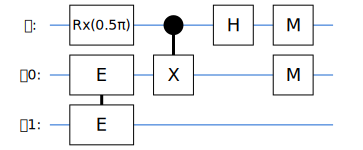

In [85]:
from cirq.contrib.svg import SVGCircuit

# 准备纠缠态的量子比特对|𝜙0⟩, |𝜙1⟩
circuit.append(EntangleGate().on(𝜙0, 𝜙1))

# CNOT门：|𝜓⟩-|𝜙0⟩，然后|𝜓⟩上加H门
circuit.append([cirq.CNOT(𝜓, 𝜙0), cirq.H(𝜓)],
               strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# 对|𝜓⟩，|𝜙0⟩进行测量
circuit.append([cirq.measure(𝜙0), cirq.measure(𝜓)],
               strategy=cirq.InsertStrategy.NEW_THEN_INLINE) 

SVGCircuit(circuit)
# print(circuit)

Alice运行这个电路，得到$|\psi\phi_0\rangle$的测量值：

In [87]:
result_alice = cirq.Simulator().simulate(circuit, qubit_order=[𝜓, 𝜙0, 𝜙1])
m_psi = int(result_alice.measurements['𝜓'][0])
m_phi0 = int(result_alice.measurements['𝜙0'][0])
print("Alice: Measure(𝜓) = {}, Measure(𝜙0) = {}".format(m_psi, m_phi0))

Alice: Measure(𝜓) = 0, Measure(𝜙0) = 0


## Bob这边的电路

假设要传送的量子比特状态是$|\psi\rangle=(\alpha|0\rangle+\beta|1\rangle)$。
Alice把前面测量得到的结果告诉Bob，然后Bob根据得到的信息，对手里的$|\phi_1\rangle$进行相应的变换，从而把它的状态变成和$|\psi\rangle$一样：
- 如果Alice测量$|\psi\phi_0\rangle$得到00，什么也不用做，$|\phi_1\rangle$状态已经是$(\alpha|0\rangle+\beta|1\rangle)$。
- 如果Alice测量$|\psi\phi_0\rangle$得到01，那么$|\phi_1\rangle=(\beta|0\rangle+\alpha|1\rangle)$，对它做一个X变换就可以变成$(\alpha|0\rangle+\beta|1\rangle)$。
- 如果Alice测量$|\psi\phi_0\rangle$得到10，那么$|\phi_1\rangle=(\alpha|0\rangle-\beta|1\rangle)$，对它做一个Z变换就可以变成$(\alpha|0\rangle+\beta|1\rangle)$。
- 如果Alice测量$|\psi\phi_0\rangle$得到11，那么$|\phi_1\rangle=(\alpha|1\rangle-\beta|0\rangle)$，对它做一个X变换再加一个Z变换，就可以变成$(\alpha|0\rangle+\beta|1\rangle)$。

怎么来模拟Bob这边的过程呢？

Bob这里有一个量子比特$|\phi_1\rangle$，当Bob得到Alice发来的测量结果后，$|\phi_1\rangle$的状态必然是上述4种状态之一。Bob要根据Alice发来的信息，决定在$|\phi_1\rangle$后面加上什么门。

In [89]:
# 根据Alice测量|𝜓𝜙0⟩ 的结果，返回要对𝜙1进行的变换
def generate_bob_circuit(m_psi, m_phi0):
    if m_psi == 0 and m_phi0 == 0:
        # 测量 |𝜓𝜙0⟩ 得到00，什么也不用做
        return cirq.Circuit()
    elif m_psi == 0 and m_phi0 == 1:
        # 测量 |𝜓𝜙0⟩ 得到01，对|𝜙1⟩做一个X变换
        return cirq.Circuit(cirq.X(𝜙1))
    elif m_psi == 1 and m_phi0 == 0:
        # 测量 |𝜓𝜙0⟩ 得到10，对|𝜙1⟩做一个Z变换
        return cirq.Circuit(cirq.Z(𝜙1))
    elif m_psi == 1 and m_phi0 == 1:
        # 测量 |𝜓𝜙0⟩ 得到11，对|𝜙1⟩做一个X变换再加Z变换
        return cirq.Circuit(cirq.X(𝜙1), cirq.Z(𝜙1))

circuit_bob = generate_bob_circuit(m_psi, m_phi0)
print("Alice: Measure(𝜓) = {}, Measure(𝜙0) = {}".format(m_psi, m_phi0))

Alice: Measure(𝜓) = 0, Measure(𝜙0) = 0


然后我们要跑Bob的电路，但这里又有个问题：

每次用Simulator跑电路，都会重新初始化其中的量子比特，所以Bob这里的$|\phi_1\rangle$会被重新初始化！

所以要模拟Bob的过程，我们需要把Bob这边的电路（即$|\phi_1\rangle$）**初始化**成Alice那边运行后的状态。这就相当于把两边的模拟过程接起来了！

所以我们要做的是：
- 在Alice运行电路后，记下运行后的状态，这个在前面的代码里，已经记在```result_alice```里了；
- 用Alice这边的$|\phi_1\rangle$状态向量，来初始化Bob这边的电路。

### 关于Cirq里的状态向量

关于状态向量，这里多解释几句。例如我们有个系统，其中有3个量子比特，分别表示成

$$
\alpha_0|0\rangle + \beta_0|1\rangle, \\
\alpha_1|0\rangle + \beta_1|1\rangle, \\
\alpha_2|0\rangle + \beta_2|1\rangle,
$$

那么这个系统的状态向量就是这3个量子比特的向量的张量积(Tensor Product/Kronecker Product)：

$$
\begin{pmatrix}
\alpha_0 \\
\beta_0
\end{pmatrix}
\otimes
\begin{pmatrix}
\alpha_1 \\
\beta_1
\end{pmatrix}
\otimes
\begin{pmatrix}
\alpha_2 \\
\beta_2
\end{pmatrix}
=
\begin{pmatrix}
\alpha_0\alpha_1\alpha_2 \\
\alpha_0\alpha_1\beta_2 \\
\alpha_0\beta_1\alpha_2 \\
\alpha_0\beta_1\beta_2 \\
\beta_0\alpha_1\alpha_2 \\
\beta_0\alpha_1\beta_2 \\
\beta_0\beta_1\alpha_2 \\
\beta_0\beta_1\beta_2
\end{pmatrix}
$$

上面的矩阵还告诉我们，如果用计算基矢(Computational Basis)来表示的话，系统的当前状态是$|000\rangle, |001\rangle, \cdots, |111\rangle$等计算基矢的叠加态：
$$
\alpha_0\alpha_1\alpha_2 |000\rangle +\\
\alpha_0\alpha_1\beta_2 |001\rangle +\\
\alpha_0\beta_1\alpha_2 |010\rangle +\\
\alpha_0\beta_1\beta_2 |011\rangle +\\
\beta_0\alpha_1\alpha_2 |100\rangle +\\
\beta_0\alpha_1\beta_2 |101\rangle +\\
\beta_0\beta_1\alpha_2 |110\rangle +\\
\beta_0\beta_1\beta_2 |111\rangle
$$

在Cirq里面，系统的状态向量就是用这样一组复数来表示，并且按照上面的Kronecker顺序排列。我们运行模拟器，返回得到的``results``里有一个``final_state``成员，就是当前系统的状态向量。例如前面我们看到：
```python
result_alice = cirq.Simulator().simulate(circuit, qubit_order=[𝜓, 𝜙0, 𝜙1])
```
如果我们查看``result_alice.final_state``，里面就有系统的状态向量，包含了8个复数。

前面我们说到，Alice的电路有三个量子比特，已经测量了前两个量子比特，现在要的是第三个的状态向量。

先看一个简单的例子，如果前两个量子比特的测量结果是00，对上面的式子意味着什么？
- 第一个量子比特测量后是$|0\rangle$，也就是说$\alpha_0=1, \beta_0=0$.
- 同理，第二个量子比特测量后也是$|0\rangle$，也就是说$\alpha_1=1, \beta_1=0$.
放到上面的式子里，整个系统的状态就变成了
$$
\alpha_0\alpha_1\alpha_2 |000\rangle +
\alpha_0\alpha_1\beta_2 |001\rangle = \\
\alpha_2 |000\rangle + \beta_2 |001\rangle
$$
因为$\beta_0=0, \beta_1=0$，其他项都变成0消掉了。

所以，如果前两个量子比特测量结果是00，那么第三个量子比特的状态就是前面8个叠加项的第一和第二项，我们只要看``result_alice.final_state``的第一和第二项，就能得到$|\phi_1\rangle$的状态：
```result_alice.final_state[0:2]```

同理：
- 如果前两个量子比特测量结果是01，那么第三个量子比特$\phi_1$的状态就在``result_alice.final_state[2:4]``里；
- 如果前两个量子比特测量结果是10，那么第三个量子比特$\phi_1$的状态就在``result_alice.final_state[4:6]``里；
- 如果前两个量子比特测量结果是11，那么第三个量子比特$\phi_1$的状态就在``result_alice.final_state[6:8]``里；

另外还要注意的是，真实的量子计算机里一般是不能获取系统的状态向量的，这种方法只适用于模拟器环境。

到这里，我们知道如何根据Alice的测量结果，得到$|\phi_1\rangle$的状态向量。接下来我们就可以用这个状态向量，来初始化Bob这边的电路，这样就把两边电路的状态接起来了。

定义一个函数，根据Alice的测量结果，返回$|\phi_1\rangle$的状态向量：

In [90]:
# 根据Alice的测量结果，返回|𝜙1⟩的状态向量，用来初始化Bob的电路
def bob_phi_1_state(m_psi, m_phi0, result_alice):
    if m_psi == 0 and m_phi0 == 0:
        return result_alice.final_state[0:2]
    elif m_psi == 0 and m_phi0 == 1:
        return result_alice.final_state[2:4]
    elif m_psi == 1 and m_phi0 == 0:
        return result_alice.final_state[4:6]
    elif m_psi == 1 and m_phi0 == 1:
        return result_alice.final_state[6:8]

bob_initial_state = bob_phi_1_state(m_psi, m_phi0, result_alice)

然后Bob运行电路的时候，用这个状态向量来初始化$|\phi_1\rangle$。在调用``Simulator``的时候，传入``initial_state``参数：

In [91]:
result_bob = cirq.Simulator().simulate(circuit_bob,
                                       qubit_order=[𝜙1],
                                       initial_state=bob_initial_state)

print("Bob     |𝜙1⟩:", np.round(result_bob.final_state, 3))
print("Alice   |𝜓⟩: ", np.round(psi_state, 3))

Bob     |𝜙1⟩: [0.707+0.j    0.   -0.707j]
Alice   |𝜓⟩:  [0.707+0.j    0.   -0.707j]


多试几次，你会发现结果都是一致的。因此，Bob那边得到了和原先$|\psi\rangle$状态一样的量子比特！

另外要注意的是，量子信息有**不可复制性**。在这个时候原先的$|\psi\rangle$已经被测量坍缩了（记得我们在Alice那边做的测量吗？），所以并不存在2个$|\psi\rangle$副本的问题。我们之所以能在这里打印出它的状态，是因为我们利用模拟器的特性，在制备的时候把它的状态向量记下来，放到这里做验证用。

## 备注：Tensor Product

$$
A \otimes B =
\begin{bmatrix}
a_{11}B & \cdots & a_{1n}B \\
\vdots & \ddots & \vdots \\
a_{1m}B & \cdots & a_{mn}B \\
\end{bmatrix}
$$